<a href="https://colab.research.google.com/github/mickymarsh/OCR-Based-Invoice-and-Receipt-Data-Extractor/blob/main/finetuneLaoutLMv3%20for%20receipts/final_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers datasets seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a0ff12d9dce933d72336b5deb591f746f2a7033208a6e6fb0131340ea3ba897c
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from datasets import Dataset

# Load your annotated dataset
with open("/content/drive/MyDrive/recipt-yolo-dataset/train2/annotations_with_token_labels.json", "r") as f:
    data = json.load(f)

# Inspect one example
print(data[0].keys())


dict_keys(['id', 'image', 'region_bboxes', 'region_labels', 'token_words', 'token_bboxes', 'token_labels'])


In [ ]:
# Collect unique labels
unique_labels = sorted(set(l for entry in data for l in entry["token_labels"]))
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}

print(label2id)


{'B-Address': 0, 'B-Date': 1, 'B-Item': 2, 'B-OrderId': 3, 'B-Subtotal': 4, 'B-Tax': 5, 'B-Title': 6, 'B-TotalPrice': 7, 'extra': 8}


In [ ]:
dataset = Dataset.from_list(data)

# Split train/valid if not already
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
valid_dataset = dataset["test"]


In [ ]:
from transformers import LayoutLMv3TokenizerFast
from datasets import Dataset
import torch # Import torch

tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")

# Alignment function
def tokenize_and_align(examples):
    tokenized_inputs = tokenizer(
        examples["token_words"],
        boxes=examples["token_bboxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

    labels = []
    for batch_index in range(len(examples["token_words"])):
        word_ids = tokenized_inputs.word_ids(batch_index=batch_index)
        example_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                example_labels.append(-100)
            elif word_idx != previous_word_idx:
                # Only label the first token of a given word.
                # Add a check for word_idx within bounds
                if word_idx < len(examples["token_labels"][batch_index]):
                    example_labels.append(label2id[examples["token_labels"][batch_index][word_idx]])
                else:
                    example_labels.append(-100) # Ignore if word_idx is out of bounds
            else:
                # Subsequent tokens of the same word get ignored label.
                example_labels.append(-100)
            previous_word_idx = word_idx
        labels.append(example_labels)

    # Convert lists to tensors
    tokenized_inputs["input_ids"] = torch.tensor(tokenized_inputs["input_ids"])
    tokenized_inputs["attention_mask"] = torch.tensor(tokenized_inputs["attention_mask"])
    tokenized_inputs["bbox"] = torch.tensor(tokenized_inputs["bbox"])
    tokenized_inputs["labels"] = torch.tensor(labels)


    # Add print statements to check shapes and types
    print("Shapes after tokenization and alignment:")
    print("input_ids:", tokenized_inputs["input_ids"].shape, tokenized_inputs["input_ids"].dtype)
    print("attention_mask:", tokenized_inputs["attention_mask"].shape, tokenized_inputs["attention_mask"].dtype)
    print("bbox:", tokenized_inputs["bbox"].shape, tokenized_inputs["bbox"].dtype)
    print("labels:", tokenized_inputs["labels"].shape, tokenized_inputs["labels"].dtype)


    return tokenized_inputs

# Recreate train_dataset and valid_dataset from the original dataset object
# This step is important to ensure we are working with the original dataset structure
# Assuming 'data' is still available from cell TmPaMbD6rWLX
dataset = Dataset.from_list(data)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
valid_dataset = dataset["test"]


train_dataset = train_dataset.map(tokenize_and_align, batched=True)
valid_dataset = valid_dataset.map(tokenize_and_align, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Shapes after tokenization and alignment:
input_ids: torch.Size([1000, 512]) torch.int64
attention_mask: torch.Size([1000, 512]) torch.int64
bbox: torch.Size([1000, 512, 4]) torch.int64
labels: torch.Size([1000, 512]) torch.int64
Shapes after tokenization and alignment:
input_ids: torch.Size([104, 512]) torch.int64
attention_mask: torch.Size([104, 512]) torch.int64
bbox: torch.Size([104, 512, 4]) torch.int64
labels: torch.Size([104, 512]) torch.int64


Map:   0%|          | 0/123 [00:00<?, ? examples/s]

Shapes after tokenization and alignment:
input_ids: torch.Size([123, 512]) torch.int64
attention_mask: torch.Size([123, 512]) torch.int64
bbox: torch.Size([123, 512, 4]) torch.int64
labels: torch.Size([123, 512]) torch.int64


In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(transformers.__version__)


4.57.0


In [ ]:
def is_valid(example):
    for (x0, y0, x1, y1) in example["bbox"]:
        if not (0 <= x0 <= 1000 and 0 <= y0 <= 1000 and 0 <= x1 <= 1000 and 0 <= y1 <= 1000):
            return False
    return True




In [ ]:
# Count before filtering
train_before = len(train_dataset)
valid_before = len(valid_dataset)

# Apply filtering
train_dataset = train_dataset.filter(is_valid)
valid_dataset = valid_dataset.filter(is_valid)

# Count after filtering
train_after = len(train_dataset)
valid_after = len(valid_dataset)

print(f"Train dataset: removed {train_before - train_after} invalid samples")
print(f"Valid dataset: removed {valid_before - valid_after} invalid samples")


Filter:   0%|          | 0/1104 [00:00<?, ? examples/s]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

Train dataset: removed 23 invalid samples
Valid dataset: removed 1 invalid samples


In [ ]:
for example in train_dataset:
    assert len(example["input_ids"]) == len(example["bbox"]), "Mismatch between tokens and boxes!"
    for box in example["bbox"]:
        assert all(0 <= v <= 1000 for v in box), f"Invalid bbox {box}"


In [ ]:
num_labels = model.config.num_labels

def check_dataset(dataset, name="dataset"):
    print(f"Checking {name}...")
    for i, ex in enumerate(dataset):
        # Check bbox length
        if len(ex["input_ids"]) != len(ex["bbox"]):
            print(f"❌ Length mismatch in {name}[{i}] -> input_ids={len(ex['input_ids'])}, bbox={len(ex['bbox'])}")
            return i

        # Check bbox values
        for box in ex["bbox"]:
            if not all(0 <= v <= 1000 for v in box):
                print(f"❌ Invalid bbox in {name}[{i}] -> {box}")
                return i

        # Check labels
        if "labels" in ex:
            for lab in ex["labels"]:
                if lab != -100 and not (0 <= lab < num_labels):
                    print(f"❌ Invalid label in {name}[{i}] -> {lab}")
                    return i
    print(f"✅ {name} looks fine!")

check_dataset(train_dataset, "train")
check_dataset(valid_dataset, "valid")


Checking train...
✅ train looks fine!
Checking valid...
✅ valid looks fine!


In [ ]:
def check_alignment(dataset, name="dataset"):
    for i, ex in enumerate(dataset):
        n_ids = len(ex["input_ids"])
        n_bbox = len(ex["bbox"])
        n_labels = len(ex["labels"]) if "labels" in ex else n_ids

        if not (n_ids == n_bbox == n_labels):
            print(f"❌ Alignment issue in {name}[{i}] -> ids={n_ids}, bbox={n_bbox}, labels={n_labels}")
            return i
    print(f"✅ {name} alignment looks fine!")

check_alignment(train_dataset, "train")
check_alignment(valid_dataset, "valid")


✅ train alignment looks fine!
✅ valid alignment looks fine!


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
from transformers import TrainingArguments, Trainer, LayoutLMv3Processor
import torch # Import torch
from evaluate import load # Corrected import
import numpy as np
from transformers import EarlyStoppingCallback

# # Move model to CPU as a diagnostic step
# device = torch.device("cpu")
# model.to(device)

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

metric = load("seqeval") # Use load from evaluate

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (all labels are -100)
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


# training_args = TrainingArguments(
#     output_dir="./layoutlmv3-receipts",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=1,  # Reduced batch size
#     per_device_eval_batch_size=1,   # Reduced batch size
#     num_train_epochs=10,
#     weight_decay=0.05,
#     logging_dir="./logs",
#     push_to_hub=False,
#     load_best_model_at_end=True,  # Load the best model based on the metric
#     metric_for_best_model="f1", # Use f1 score to determine the best model

# )

training_args = TrainingArguments(
    output_dir="./layoutlmv3-receipts",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=6,
    weight_decay=0.05,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
)


# Assuming processor was defined elsewhere, e.g., in cell 4Kd9PAZ03Yyk
# If not, you might need to instantiate it here:
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    processing_class=processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: janodi-22 (janodi-22-univercity-of-moratuwa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.541931,0.755477,0.761421,0.758438,0.839800
2,0.790300,0.401113,0.828579,0.832995,0.830781,0.885169
3,0.790300,0.354148,0.842444,0.864467,0.853313,0.901909
4,0.323200,0.344841,0.862241,0.876904,0.869511,0.915207
5,0.323200,0.323766,0.877086,0.880203,0.878642,0.921151
6,0.202800,0.330972,0.877330,0.884010,0.880657,0.922247


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: extra seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: extra seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: extra seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.p

TrainOutput(global_step=1626, training_loss=0.41887096344031677, metrics={'train_runtime': 1094.8781, 'train_samples_per_second': 5.924, 'train_steps_per_second': 1.485, 'total_flos': 1709774900840448.0, 'train_loss': 0.41887096344031677, 'epoch': 6.0})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Save the model and tokenizer
trainer.save_model("/content/layoutlmv3-finetuned-receipts")
tokenizer.save_pretrained("/content/layoutlmv3-finetuned-receipts")

# Load the processor and save it to the same directory
from transformers import LayoutLMv3Processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
processor.save_pretrained("/content/layoutlmv3-finetuned-receipts")

# Replace "your-username/your-model-name" with your desired repository name on the Hugging Face Hub
model_name = "janodis/layoutlmv3-refinetuned-receipts"

# Push the model and processor to the Hub
# Ensure you have run the notebook_login() cell first
try:
    # Push the model and processor using their respective push_to_hub methods
    # Assuming 'model' and 'processor' objects are available in the environment
    # If not, you might need to reload them from the saved directory first
    model.push_to_hub(model_name)
    processor.push_to_hub(model_name)
    print(f"Model and processor pushed to https://huggingface.co/{model_name}")
except Exception as e:
    print(f"Error pushing to Hugging Face Hub: {e}")
    print("Please ensure you have run the notebook_login() cell and have the necessary permissions.")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...u8t_c7i/model.safetensors:   0%|          |  552kB /  501MB            

README.md: 0.00B [00:00, ?B/s]

Model and processor pushed to https://huggingface.co/janodis/layoutlmv3-refinetuned-receipts


In [ ]:
results = trainer.evaluate()
print(results)


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: extra seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.3309715688228607, 'eval_precision': 0.8773299748110831, 'eval_recall': 0.8840101522842639, 'eval_f1': 0.8806573957016435, 'eval_accuracy': 0.9222465581977471, 'eval_runtime': 5.8724, 'eval_samples_per_second': 20.775, 'eval_steps_per_second': 20.775, 'epoch': 6.0}


In [ ]:

!pip install easyocr



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 22.2 MB/s eta 0:00:00


In [ ]:
import easyocr
from PIL import Image


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 1007-receipt.jpg to 1007-receipt.jpg


preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


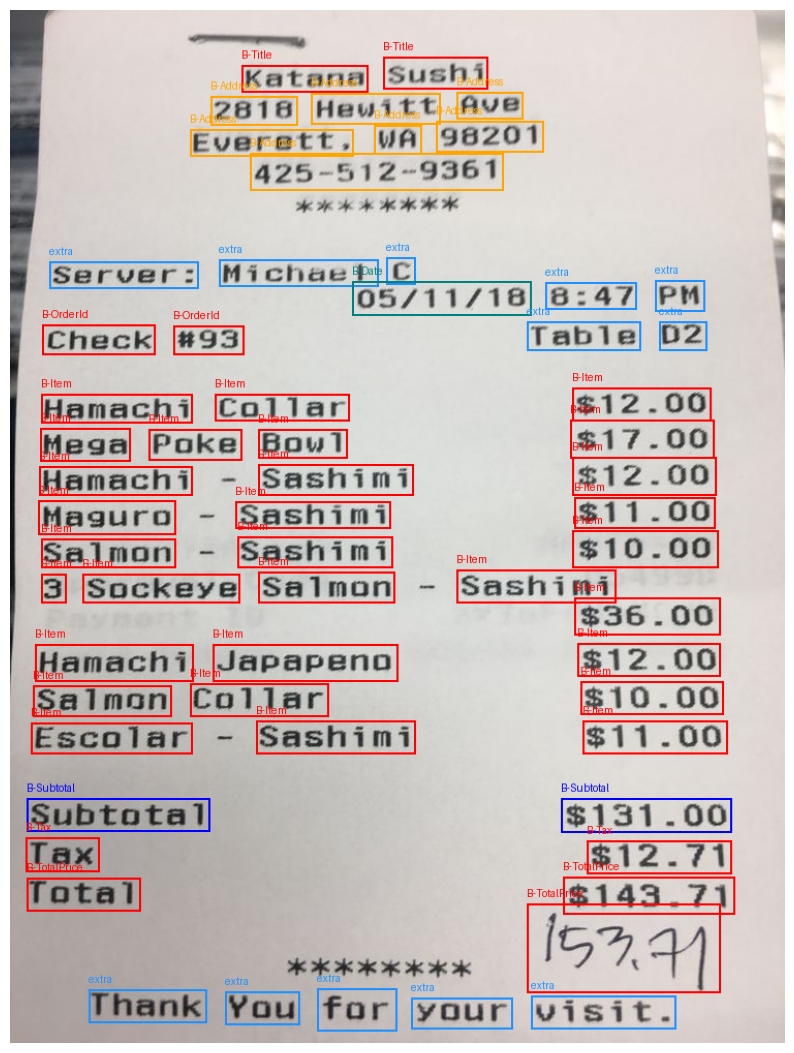

{'B-Title': ['Katana', 'Sushi'], 'B-Address': ['2818', 'Hewitt', 'Ave', 'Everett.', 'WA', '98201', '425-512-9361'], 'extra': ['Server:', 'Michae|', 'c', '8 : 47', 'PM', 'Table', '02', 'Thank', 'You', 'for', 'your', 'visit.'], 'B-Date': ['05/11/18'], 'B-OrderId': ['Check', '#93'], 'B-Item': ['Hamachi', 'Collar', '812.00', 'Mega', 'Poke', 'Bow 1', '817.00', 'Hamachi', 'Sashimi', '$12.00', 'Maguro', 'Sashim i', '811.00', 'Salmon', 'Sashimi', '810.00', '3', 'Sockeye', 'Salmon', 'Sashim i', '836 . 00', 'Hamachi', 'Japapeno', '812.00', 'Samon', 'Collar', '810. 00', 'Escolar', 'Sashimi', '811.00'], 'B-Subtotal': ['Subtotal', '8131.00'], 'B-Tax': ['Tax', '812.71'], 'B-TotalPrice': ['Total', '8143.71', '15741']}


In [ ]:
import torch
from PIL import Image, ImageDraw, ImageFont # Import ImageDraw here
import easyocr
import matplotlib.pyplot as plt
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification

# Replace with your model name on the Hugging Face Hub
model_name = "janodis/layoutlmv3-refinetuned-receipts"

# Load processor and model from the Hub
processor = LayoutLMv3Processor.from_pretrained(model_name, apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(model_name)
id2label = model.config.id2label

# Assuming you have uploaded a new image and its path is stored in a variable, e.g., new_image_path
# For demonstration, I'll reuse the previously uploaded image path
new_image_path = "/content/1007-receipt.jpg"

# 1) OCR with EasyOCR
reader = easyocr.Reader(['en'])   # add languages if needed
raw = reader.readtext(new_image_path)  # each: [poly, text, conf]
img = Image.open(new_image_path).convert("RGB")
W, H = img.size

# 2) Convert polys -> boxes, filter, and collect (x1,y1,x2,y2) in pixels
tmp = []
CONF_THRESH = 0.35
for poly, text, conf in raw:
    if not text or conf < CONF_THRESH:
        continue
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    x1, y1, x2, y2 = max(0, min(xs)), max(0, min(ys)), min(W, max(xs)), min(H, max(ys))
    tmp.append((text, [x1, y1, x2, y2]))

# 3) Sort into reading order (line-wise by y-center, then x)
def reading_order(entries, y_tol=0.015):
    # entries: list of (text, [x1,y1,x2,y2])
    # group by approximate line using y-center tolerance
    lines = {}
    for t, (x1,y1,x2,y2) in entries:
        yc = (y1+y2)/2
        placed = False
        for k in list(lines.keys()):
            if abs(k - yc) <= y_tol*H:
                lines[k].append((t, [x1,y1,x2,y2]))
                placed = True
                break
        if not placed:
            lines[yc] = [(t, [x1,y1,x2,y2])]
    # sort lines by y, and words in line by x
    ordered = []
    for k in sorted(lines.keys()):
        line = sorted(lines[k], key=lambda e: e[1][0])
        ordered.extend(line)
    return ordered

ordered = reading_order(tmp)

# 4) Build words + normalized boxes for processor (0..1000 int, clamped)
words = []
boxes = []
for t, (x1, y1, x2, y2) in ordered:
    b = [
        int(1000 * x1 / W),
        int(1000 * y1 / H),
        int(1000 * x2 / W),
        int(1000 * y2 / H),
    ]
    # clamp strictly into [0,1000]
    b = [min(1000, max(0, v)) for v in b]
    words.append(t)
    boxes.append(b)

if len(words) == 0:
    raise ValueError("No OCR words after filtering. Lower CONF_THRESH or check the image.")


# Prepare inputs
encoding = processor(
    images=img,
    text=words,
    boxes=boxes,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=512,

)

# Run inference with model
with torch.no_grad():
    outputs = model(**encoding)

# Get predictions
logits = outputs.logits
pred_ids = logits.argmax(-1).squeeze(0).tolist()

# 7) Convert token-level preds -> word-level preds using word_ids
word_ids = encoding.word_ids(batch_index=0)  # list length = seq_len
word_level_labels = []
used = set()
for tok_idx, widx in enumerate(word_ids):
    if widx is None or widx in used:
        continue
    used.add(widx)
    word_level_labels.append(id2label[pred_ids[tok_idx]])

# Sanity: align lengths
word_level_labels = word_level_labels[:len(words)]
assert len(word_level_labels) == len(words), f"Mismatch: {len(word_level_labels)} vs {len(words)}"

# 8) Draw colored boxes + labels back on the image
draw = ImageDraw.Draw(img)
COLOR_MAP = {
    "B-Title":    (255, 0, 0),      # red
    "B-Address":  (255, 165, 0),    # orange
    "B-Items":    (0, 128, 0),      # green
    "B-Subtotal": (0, 0, 255),      # blue
    "B-Discount": (138, 43, 226),   # purple
    "B-Total":    (220, 20, 60),    # crimson
    "B-Date":     (0, 128, 128),    # teal
    "extra":      (30, 144, 255),   # dodgerblue
}
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
except:
    font = ImageFont.load_default()

for (t, (x1,y1,x2,y2)), label in zip(ordered, word_level_labels):
    color = COLOR_MAP.get(label, (255, 0, 0))
    draw.rectangle([x1, y1, x2, y2], width=2, outline=color)
    ty = max(0, y1 - 16)
    draw.text((x1, ty), label, fill=color, font=font)

plt.figure(figsize=(10,14))
plt.imshow(img)
plt.axis("off")
plt.show()

# 9) (Optional) build a quick structured dict by label buckets
structured = {}
for w, lab in zip(words, word_level_labels):
    structured.setdefault(lab, []).append(w)

print(structured)